In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import ltn
import matplotlib.pyplot as plt
import random
import os

from utils_order import adjacency_anti_transitive, adjacency_triangular_lattice, adjacency_lattice, \
adjacency_total_order, adjacency_from_string, get_pairs_adjacency, get_samples_adjacency, \
get_constants, get_pairs_total_order, get_samples_total_order, get_eye_3D, get_sat, \
BaselineRelationalModel, BaselineRelationalModelConcat, AbstractorOrderModel, BaselineRelationalIndependentModel, plot_mp

from custom_fuzzy_ops import ImpliesReichenbachSigmoidal

In [22]:
class InvModel(nn.Module):
    def __init__(self, invariance="symmetric", hidden_sizes=[16], Win=8, Wout=8):
        super(InvModel, self).__init__()

        self.invariance = invariance

        # Determine input size based on invariance type
        if self.invariance == "none":
            input_size = Wout * 2  # No invariance, concatenate x and y
        else:
            Wout = Wout * 2  # Double Wout for invariance
            input_size = Wout

        self.W = nn.Linear(in_features=Win, out_features=Wout)

        # Initialize hidden layers
        self.hidden_sizes = hidden_sizes
        layers = []
        for hidden_size in self.hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size, bias=False))
            layers.append(nn.Tanh())
            input_size = hidden_size
        layers.append(nn.Linear(input_size, 1, bias=False))  # Output layer
        self.layers = nn.Sequential(*layers)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        x = self.W(x)
        y = self.W(y)
        if self.invariance == "symmetric":
            xy = x + y
        elif self.invariance == "asymmetric":
            xy = x - y
        elif self.invariance == "none":
            xy = torch.cat([x, y], dim=-1)
        xy = self.layers(xy)
        truth = self.sigmoid(xy)
        return truth

In [23]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

In [24]:
def train(model, constants_tensor, epoch_steps=50, epochs=1000, reflective=True, transitive=True, anti_transitive=False,
          symmetric=False,
          anti_symmetric=True, 
          connected=True,
          LEM=True,
          neg_examples=None, pos_examples=None, lr=0.001,
          switch=False,
          Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach()),
          Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f"),
          Forall_custom=ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=10, stable=True), quantifier='f'),
          first_run=True,
          sat_agg=ltn.fuzzy_ops.SatAgg(),
          ground_truth=None,
          verbose=True):
    
    
    heatmap_data = []
    train_loss = []

    if first_run:
        x1 = ltn.Variable("x1", constants_tensor)
        x2 = ltn.Variable("x2", constants_tensor)
        query = model(x1,x2).value.detach().numpy()
        heatmap_data.append(query)


    # we need to learn the parameters of the predicate C
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    last_loss = np.inf
    

    for epoch in range(epochs):
        optimizer.zero_grad()

        x1 = ltn.Variable("x1", constants_tensor)
        x2 = ltn.Variable("x2", constants_tensor)
        x3 = ltn.Variable("x3", constants_tensor)

        fuzzy_theory = []
        fuzzy_weighted = []
        if pos_examples is not None:
            pos_x = ltn.Variable("pos_x", constants_tensor[pos_examples[:,0]])
            pos_y = ltn.Variable("pos_y", constants_tensor[pos_examples[:,1]])
            pos_x, pos_y = ltn.diag(pos_x, pos_y)
            axiom_pos = Forall([pos_x, pos_y], model(pos_x, pos_y))
            fuzzy_theory.append(axiom_pos)
        if neg_examples is not None:
            neg_x = ltn.Variable("neg_x", constants_tensor[neg_examples[:,0]])
            neg_y = ltn.Variable("neg_y", constants_tensor[neg_examples[:,1]])
            neg_x, neg_y = ltn.diag(neg_x, neg_y)
            axiom_neg = Forall([neg_x, neg_y], Not(model(neg_x, neg_y)))
            fuzzy_theory.append(axiom_neg)

        if reflective:
            fuzzy_theory.append(Forall(x1, model(x1, x1)))
        if transitive:
            eye_3D = torch.zeros(num_objects, num_objects, num_objects)
            for i in range(num_objects):
                eye_3D[i, i, i] = 1
            eye_3D = eye_3D.bool()
            fuzzy_weighted.append(
                Forall_custom([x1, x2, x3], Implies(And(model(x1, x2), model(x2, x3)), model(x1, x3)),
                                              cond_vars=[x1, x2, x3],
                                              cond_fn=lambda x, y, z: eye_3D))

                                            


        if anti_transitive:
            fuzzy_weighted.append(Forall_custom([x1, x2, x3], Implies(And(model(x1, x2), model(x2, x3)), Not(model(x1, x3))),) )

        if symmetric:
            fuzzy_theory.append(Forall_custom([x1, x2],
                Implies(model(x1, x2), model(x2, x1)),
                cond_vars=[x1, x2],
                cond_fn=lambda x, y: ~torch.eye(num_objects, dtype=bool),
                ))

        if anti_symmetric:
            fuzzy_theory.append(Forall([x1, x2],
                Implies(model(x1, x2), Not(model(x2, x1))),
                cond_vars=[x1, x2],
                cond_fn=lambda x, y: ~torch.eye(num_objects, dtype=bool),
                ))
            
        if connected:
            axiom_connected = Forall_custom([x1, x2],
                Or(model(x1, x2), model(x2, x1)),
                )

            fuzzy_theory.append(axiom_connected)
        
        if LEM:
            axiom_lem = Forall_custom([x1, x2],
                Or(model(x1, x2), Not(model(x1, x2))),
                )
            # axiom_lem = Forall_custom([x1, x2],
            #     Implies(Not(model(x1, x2)), model(x1, x2)),
            #     )

            fuzzy_theory.append(axiom_lem)

        weighted = False
        if weighted:
            sat_weight = 0.9
            satisfiablity = sat_weight * sat_agg(*fuzzy_theory) + (1 - sat_weight) * sat_agg(*fuzzy_weighted)
        else:
            fuzzy_theory += fuzzy_weighted
            satisfiablity = sat_agg(*fuzzy_theory)


        loss = 1. - satisfiablity
        loss.backward()
        optimizer.step()
        
        if epoch%epoch_steps == 0:
            with torch.no_grad():
                train_loss.append(loss.item())
                if verbose:
                    print("Epoch %d: Train Sat Level %.3f "%(epoch, satisfiablity))
                query = model(x1,x2).value.detach().numpy()
                heatmap_data.append(query)
                if ground_truth is not None:
                    pred = torch.tensor(query > 0.5)
                    val_acc = (pred == ground_truth).sum() / (ground_truth.shape[0]**2)
                    if verbose or True:
                        print("Overall acc %.3f "%(val_acc))

                    mask = ~torch.eye(object_dim).bool()
                    if verbose:
                        print("Overall sat %.3f"%(get_sat(query, ground_truth, mask=mask, p=1)))

                # if np.allclose(loss.item(), last_loss, atol=1e-04, equal_nan=False) and epoch>25:
                # # 1 - loss > 0.995 or 
                
                #     if switch:
                #         print()
                #         print(epoch/epoch_steps)
                #         torch.save(model, f"checkpoints/chain_{object_dim}.PT")
                #         # break
                    
                #         switch = False
                #         transitive = True
                #         # Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=6), quantifier="f")
                #     else:
                #         break


            
            
            # last_loss = loss
    if verbose:
        print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss))
    
    return heatmap_data, train_loss, 

In [25]:
def set_training(num_objects = 32, object_dim = None, feature_type = "onehot" ,pos_chain_depth = 1,
    train_split_pos = 0.,
    train_split_neg = 0.,):
    if object_dim is None:
        object_dim = num_objects

    # adjacency = adjacency_anti_transitive(num_objects)
    # adjacency = adjacency_triangular_lattice(num_objects)
    # adjacency = adjacency_lattice(num_objects, 
    #                               dim=2,
    #                             #   dim=int(np.log2(num_objects))
    #                             distance=3,
    #                             periodic=False
    #                               )
    # adjacency = adjacency_from_string(num_objects, "O")
    adjacency = adjacency_total_order(num_objects)


    # plt.imshow(adjacency, cmap='hot')
    # plt.show()
    # nx.draw(G, with_labels=True, arrows=True, pos=pos)


    constants, constants_tensor = get_constants(num_objects, object_dim, feature_type)
    # pos_pairs, neg_pairs = get_pairs_adjacency(adjacency=adjacency)
    # pos_sample, neg_sample = get_samples_adjacency(pos_pairs, neg_pairs, train_split_pos, train_split_neg)

    pos_pairs, neg_pairs = get_pairs_total_order(num_objects)
    pos_sample, neg_sample = get_samples_total_order(num_objects, pos_pairs, neg_pairs, pos_chain_depth, train_split_pos, train_split_neg)
    eye_3D = get_eye_3D(num_objects)
    return num_objects, object_dim, adjacency, constants, constants_tensor, pos_pairs, neg_pairs, pos_sample, neg_sample, eye_3D

In [52]:
(num_objects, object_dim, adjacency, 
 constants, constants_tensor, pos_pairs, 
 neg_pairs, pos_sample, neg_sample, 
 eye_3D) = set_training(num_objects = 32, object_dim = None, 
                        # feature_type = "index" ,
                        feature_type = "onehot" ,
                        pos_chain_depth = False,
                        train_split_pos = 0.05,
                        train_split_neg = 0.05)

pos_examples = pos_sample 
neg_examples = neg_sample

# pos_examples = torch.Tensor([[i, i+1] for i in range(8-1)]).int()[[0,2,4,5,6]]
# neg_examples = torch.Tensor([[i+2, i] for i in range(8-2)]).int()

train_kwargs = dict(
    epochs=100, epoch_steps=5,
    reflective=False,
    transitive=True,
    anti_transitive=False,
    symmetric=False,
    anti_symmetric=False,
    connected=False,
    LEM=False,
    pos_examples=pos_examples,
    neg_examples=neg_examples,
    # lr=0.01,
    lr=0.01,
    constants_tensor=constants_tensor,
    switch=False,
    ground_truth=adjacency
)

In [55]:
first_run = True
if first_run:
    heatmap_data_abstr = []
    train_loss=[]
    model = ltn.Predicate(InvModel(invariance="none", hidden_sizes=[32,32], Win=object_dim, Wout=8))
    # model = ltn.Predicate(InvModel(invariance="asymmetric", hidden_sizes=[32,32], Win=object_dim, Wout=8))

heatmap_data_abstr_last, train_loss_last = train(model, **train_kwargs, first_run=first_run, verbose=False)
heatmap_data_abstr += heatmap_data_abstr_last
train_loss += train_loss_last

Overall acc 0.547 
Overall acc 0.680 
Overall acc 0.744 
Overall acc 0.772 
Overall acc 0.792 
Overall acc 0.792 
Overall acc 0.779 
Overall acc 0.776 
Overall acc 0.769 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.770 
Overall acc 0.771 
Overall acc 0.771 
Overall acc 0.771 


interactive(children=(IntSlider(value=0, description='Frame', max=20), Output()), _dom_classes=('widget-intera…

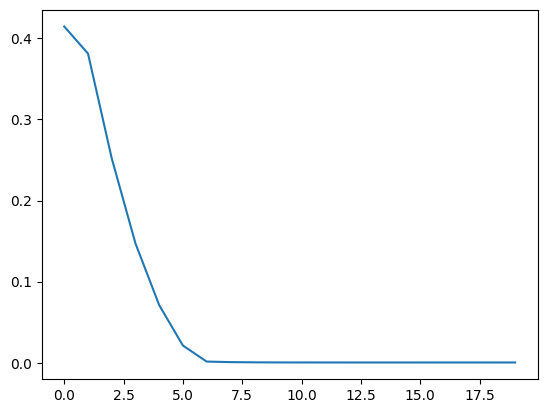

In [56]:
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)
plt.plot(train_loss)
plt.show()

interactive(children=(IntSlider(value=0, description='Frame', max=20), Output()), _dom_classes=('widget-intera…

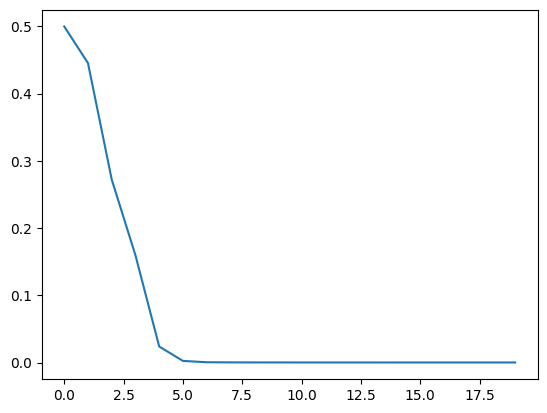

In [49]:
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)
plt.plot(train_loss)

In [30]:
assert False

AssertionError: 

In [ ]:
orderabstractor_kwargs = {
    "num_layers": 1,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": False,
    "use_learned_symbols": False,
    "learn_symbol_per_position": False,
    "use_symbolic_attention": True,
    "object_dim": object_dim,
    "symbol_dim": 64,  # Using a different symbol dimension
    "num_heads": 1,
    "ff_dim": 32,
    "dropout": 0.1,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": torch.nn.Identity(),  # Different activation function
        # "activation": nn.Softmax(-1),
        # "activation": nn.Sigmoid(),
        # "activation": sparsemax,
        "use_scaling": True,
        "shared_kv_proj": True,
    },
}

first_run = True
if first_run:
    heatmap_data_abstr = []
    train_loss=[]
    AOM = ltn.Predicate(AbstractorOrderModel(object_dim, orderabstractor_kwargs))
heatmap_data_abstr_last, train_loss_last = train(AOM, **train_kwargs, first_run=first_run)
heatmap_data_abstr += heatmap_data_abstr_last
train_loss += train_loss_last

In [ ]:
assert False

In [ ]:
train_kwargs["Forall"] = ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=10, stable=True), quantifier='f')
train_kwargs["Forall_custom"]= ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=10, stable=True), quantifier='f')
train_kwargs["sat_agg"] = ltn.fuzzy_ops.SatAgg(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True))
train_kwargs["Implies"] = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
# train_kwargs["Implies"] = ltn.Connective(ltn.fuzzy_ops.ImpliesGodel())

# train_kwargs["Implies"] = list(Implies_dict.values())[1]
print(train_kwargs["Implies"])


first_run = True
if first_run:
    heatmap_data_ind = []
    train_loss=[]
    model = BaselineRelationalIndependentModel(object_dim)
    shape = model.lin.weight.shape
    model.lin.weight = torch.nn.Parameter(torch.ones(shape)-0.+torch.rand(shape), requires_grad=True)
    AOM = ltn.Predicate(model)
heatmap_data_ind_last, train_loss_last = train(AOM, **train_kwargs, first_run=first_run)
heatmap_data_ind += heatmap_data_ind_last
train_loss += train_loss_last


In [ ]:
plot_mp(heatmap_data_ind, pos_examples=pos_examples, neg_examples=neg_examples)
plt.plot(train_loss)

In [ ]:
assert False

In [ ]:
(num_objects, object_dim, adjacency, 
 constants, constants_tensor, pos_pairs, 
 neg_pairs, pos_sample, neg_sample, 
 eye_3D) = set_training(num_objects = 32, object_dim = None, 
                        # feature_type = "index" ,
                        feature_type = "onehot" ,
                        pos_chain_depth = 1,
                        train_split_pos = 0,
                        train_split_neg = 0.1)

pos_examples = pos_sample 
neg_examples = neg_sample

# pos_examples = torch.Tensor([[i, i+1] for i in range(8-1)]).int()[[0,2,4,5,6]]
# neg_examples = torch.Tensor([[i+2, i] for i in range(8-2)]).int()

train_kwargs = dict(
    epochs=100, epoch_steps=5,
    reflective=False,
    transitive=True,
    anti_transitive=False,
    symmetric=False,
    anti_symmetric=True,
    connected=True,
    LEM=False,
    pos_examples=pos_examples,
    neg_examples=neg_examples,
    # lr=0.01,
    lr=0.01,
    constants_tensor=constants_tensor,
    switch=False,
    ground_truth=adjacency
)

In [ ]:
train_kwargs["Forall"] = ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True), quantifier='f')
train_kwargs["Forall_custom"]= ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=10, stable=True), quantifier='f')
train_kwargs["sat_agg"] = ltn.fuzzy_ops.SatAgg(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True))
train_kwargs["Implies"] = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())


first_run = True
if first_run:
    heatmap_data_abstr = []
    AOM = ltn.Predicate(AbstractorOrderModel(object_dim, orderabstractor_kwargs))
    # AOM = ltn.Predicate(BaselineRelationalModelConcat(object_dim, object_dim))

heatmap_data_abstr += train(AOM, **train_kwargs, first_run=first_run)


In [ ]:
# rules
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
assert False

In [ ]:
Godel = dict(
    Not = ltn.Connective(ltn.fuzzy_ops.NotGodel()),
    And = ltn.Connective(ltn.fuzzy_ops.AndMin()),
    Or = ltn.Connective(ltn.fuzzy_ops.OrMax()),
    Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesGodel()),
)

KleeneDienes = dict(
    Not = ltn.Connective(ltn.fuzzy_ops.NotGodel()),
    And = ltn.Connective(ltn.fuzzy_ops.AndMin()),
    Or = ltn.Connective(ltn.fuzzy_ops.OrMax()),
    Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesKleeneDienes()),
)

Goguen = dict(
    Not = ltn.Connective(ltn.fuzzy_ops.NotStandard()),
    And = ltn.Connective(ltn.fuzzy_ops.AndProd()),
    Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum()),
    Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesGoguen()),
)

Reichenbach = dict(
    Not = ltn.Connective(ltn.fuzzy_ops.NotStandard()),
    And = ltn.Connective(ltn.fuzzy_ops.AndProd()),
    Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum()),
    Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach()),
)

Luk = dict(
    Not = ltn.Connective(ltn.fuzzy_ops.NotStandard()),
    And = ltn.Connective(ltn.fuzzy_ops.AndLuk()),
    Or = ltn.Connective(ltn.fuzzy_ops.OrLuk()),
    Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesLuk()),
)

Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")


In [ ]:
Forall_pmean_error_p2 = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Forall_pmean_error_p10 = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=10), quantifier="f")
Forall_min = ltn.Quantifier(ltn.fuzzy_ops.AggregMin(), quantifier="f")
Forall_mean = ltn.Quantifier(ltn.fuzzy_ops.AggregMean(), quantifier="f")

Forall_dict = dict(
Forall_pmean_error_p2=Forall_pmean_error_p2,
Forall_pmean_error_p10=Forall_pmean_error_p10,
Forall_min=Forall_min,
Forall_mean=Forall_mean,
)

Implies_reichenbach = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Implies_kleene_diene = ltn.Connective(ltn.fuzzy_ops.ImpliesKleeneDienes())
Implies_godel = ltn.Connective(ltn.fuzzy_ops.ImpliesGodel())
Implies_Goguen = ltn.Connective(ltn.fuzzy_ops.ImpliesGoguen())
Implies_Luk = ltn.Connective(ltn.fuzzy_ops.ImpliesLuk())

Implies_Reichen_sigm_s3 = ltn.Connective(ImpliesReichenbachSigmoidal(s=3))
Implies_Reichen_sigm_s9 = ltn.Connective(ImpliesReichenbachSigmoidal(s=9))
Implies_Reichen_sigm_s18 = ltn.Connective(ImpliesReichenbachSigmoidal(s=18))



Implies_dict = dict(
    Implies_reichenbach=Implies_reichenbach,
Implies_kleene_diene=Implies_kleene_diene,
Implies_godel=Implies_godel,
Implies_Luk=Implies_Luk,
Implies_Goguen=Implies_Goguen,
Implies_Reichen_sigm_s3=Implies_Reichen_sigm_s3,
Implies_Reichen_sigm_s9=Implies_Reichen_sigm_s9,
Implies_Reichen_sigm_s18=Implies_Reichen_sigm_s18,
)

In [ ]:
import pickle
with open(f'trans_abl_{object_dim}_independent.pkl', 'rb') as f:
    results = pickle.load(f)
# object_dim = 32
# with open(f'trans_abl_{object_dim}_independent.pkl', 'rb') as f:
#     results[object_dim] = pickle.load(f)

In [ ]:
train_kwargs["sat_agg"] = ltn.fuzzy_ops.SatAgg(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True))

# results = {}

for Forall in Forall_dict:
    # results[Forall] = {}
    # for Implies in Implies_dict:
    for Implies in ["Implies_Luk"]:

        train_kwargs["Forall"] = Forall_dict[Forall]
        train_kwargs["Forall_custom"] = Forall_dict[Forall]
        train_kwargs["Implies"] = Implies_dict[Implies]

        IOM = ltn.Predicate(BaselineRelationalIndependentModel(num_objects))
        results[Forall][Implies] = train(IOM, **train_kwargs, first_run=True)

In [ ]:
import pickle
# Save to a pickle file
with open(f'trans_abl_{object_dim}_independent.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
assert False

In [ ]:
trans_abl_last = [results[a][b][-1] for a in results for b in results[a]]
plot_mp(trans_abl_last, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
i = 40
for Forall in Forall_dict:
    for Implies in Implies_dict:
        data = results[Forall][Implies]
        file_name = f"{Forall}_{Implies}_{50*i}_{object_dim}.png"
        save_plot_heatmap(data[i], pos_examples=pos_examples, file_name=file_name)
        break
    break


In [ ]:
def save_plot_heatmap(data, pos_examples, file_name, text=None):
    plt.imshow(data, cmap="PuBu", vmin=0, vmax=1)
    # plt.colorbar()
    if text:
        plt.title(text)

    # Mark specific grids (if provided)
    for row, col in pos_examples:
        plt.gca().add_patch(
            plt.Rectangle(
                (col - 0.475, row - 0.475),
                0.95,
                0.95,
                edgecolor="yellow",
                fill=False,
                lw=1,
            )
        )
    data_dir = "plots/trans_abl"
    file_path = os.path.join(
                data_dir,
                file_name
            )
    plt.savefig(
        file_path,
        # dpi=dpi,
        bbox_inches="tight",
        pad_inches=0.0,
    )

In [ ]:
def plot_heatmap(data, text, pos_examples):
    plt.imshow(data, cmap="PuBu", vmin=0, vmax=1)
    plt.colorbar()
    plt.title(text)

    # Mark specific grids (if provided)
    for row, col in pos_examples:
        plt.gca().add_patch(
            plt.Rectangle(
                (col - 0.475, row - 0.475),
                0.95,
                0.95,
                edgecolor="yellow",
                fill=False,
                lw=1,
            )
        )

    plt.show()

In [ ]:
train_kwargs["sat_agg"] = ltn.fuzzy_ops.SatAgg(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True))

results = {}

for Forall in Forall_dict:
    results[Forall] = {}
    for Implies in Implies_dict:
        train_kwargs["Forall"] = Forall_dict[Forall]
        train_kwargs["Forall_custom"] = Forall_dict[Forall]
        train_kwargs["Implies"] = Implies_dict[Implies]

        IOM = ltn.Predicate(BaselineRelationalIndependentModel(num_objects))
        results[Forall][Implies] = train(IOM, **train_kwargs, first_run=True)

In [ ]:
assert False

In [ ]:
train_kwargs["Forall"] = ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True), quantifier='f')
train_kwargs["sat_agg"] = ltn.fuzzy_ops.SatAgg(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=2, stable=True))

first_run = True
if first_run:
    heatmap_data_abstr = []
    AOM = ltn.Predicate(AbstractorOrderModel(object_dim, orderabstractor_kwargs))
heatmap_data_abstr += train(AOM, **train_kwargs, first_run=first_run)

In [ ]:
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
first_run = True
if first_run:
    heatmap_data_base_concat = []
    AOM = ltn.Predicate(BaselineRelationalModelConcat(num_objects=num_objects, object_dim=object_dim))
heatmap_data_base_concat += train(AOM, **train_kwargs, first_run=first_run)

In [ ]:
plot_mp(heatmap_data_base_concat, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
assert False

In [ ]:
# # AOM = ltn.Predicate(AbstractorOrderModel(orderabstractor_kwargs))
# train_kwargs["Forall"] = ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=20, stable=True), quantifier='f')

# train_kwargs["Implies"] = Implies_godel
# train_kwargs["transitive"]=True,
# train_kwargs["switch"]=False

# AOM = torch.load(f"checkpoints/chain_{object_dim}.PT")
# heatmap_data_abstr = train(AOM, **train_kwargs)

In [ ]:
# plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
assert False

In [ ]:
trans_abl08 = []

train_kwargs["Forall"] = ltn.Quantifier(agg_op=ltn.fuzzy_ops.AggregPMeanError(p=4, stable=True), quantifier='f')

train_kwargs["Implies"] = Implies_godel
train_kwargs["transitive"]=True,
train_kwargs["switch"]=False

# for Forall in Foralls_list:
#     train_kwargs["Forall"] = Forall

for Implies in Implies_list:
    train_kwargs["Implies"] = Implies
    AOM = torch.load(f"checkpoints/chain_{object_dim}.PT")
    # AOM = ltn.Predicate(AbstractorOrderModel(orderabstractor_kwargs))
    trans_abl08.append(train(AOM, **train_kwargs))

In [ ]:
import pickle
# Save to a pickle file
with open(f'trans_abl_{object_dim}_PMeanErrorp=4_w09.pkl', 'wb') as f:
    pickle.dump(trans_abl08, f)

In [ ]:
# i = 0
# for Forall in Foralls_list:

#     for Implies in Implies_list:
#         print(i, Forall.agg_op, Implies.connective_op)
#         i +=1

In [ ]:
trans_abl08_last = [a[-1] for a in trans_abl08]
plot_mp(trans_abl08_last, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
plot_mp(trans_abl08[0], pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
plot_mp(trans_abl[-1], pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
trans_abl_end = [a[-1] for a in trans_abl]
plot_mp(trans_abl_end, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
i=0
Implies(And(AOM(c[i], c[i+1]), AOM(c[i+1], c[i+2])), AOM(c[i], c[i+2]))


In [ ]:
3, 8, 10, 11
i = 0
for Forall in Foralls_list:
    for Implies in Implies_list:
        if i == 11:
            print(Forall.agg_op, Implies.connective_op)
            plot_mp(trans_abl[i], pos_examples=pos_examples, neg_examples=neg_examples)
        i+=1

In [ ]:
R = ltn.Predicate(BaselineRelationalModel(num_objects, object_dim, final_size=8))
heatmap_data_R = train(R, **train_kwargs)

In [ ]:
plot_mp(heatmap_data_R, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
Rcat = ltn.Predicate(BaselineRelationalModelConcat(num_objects, object_dim))
heatmap_data_Rcat = train(Rcat, **train_kwargs)

In [ ]:
plot_mp(heatmap_data_Rcat, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
AOM = ltn.Predicate(AbstractorOrderModel(orderabstractor_kwargs))
heatmap_data_abstr = train(AOM, **train_kwargs)

In [ ]:
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
orderabstractor_kwargs = {
    "num_layers": 1,
    "norm": None,  # Example normalization layer
    "use_pos_embedding": True,
    "use_learned_symbols": False,
    "learn_symbol_per_position": False,
    "use_symbolic_attention": False,
    "object_dim": object_dim,
    "symbol_dim": 64,  # Using a different symbol dimension
    "num_heads": 1,
    "ff_dim": 64,
    "dropout": 0.1,
    "MHA_kwargs": {
        "use_bias": False,
        "activation": nn.Identity(),  # Different activation function
        # "activation": nn.Softmax(-1),
        # "activation": nn.Sigmoid(),
        # "activation": sparsemax,
        "use_scaling": True,
        "shared_kv_proj": False,
    },
}


In [ ]:
AOM = ltn.Predicate(AbstractorOrderModel(orderabstractor_kwargs))
heatmap_data_abstr = train(AOM, **train_kwargs)

In [ ]:
plot_mp(heatmap_data_abstr, pos_examples=pos_examples, neg_examples=neg_examples)

In [ ]:
# i = 0
# data = heatmap_data_R[i]
# plt.imshow(data, cmap="viridis", vmin=0, vmax=1)
# plt.colorbar()
# plt.title(f"Prediction after {20 * i} epoch")
# plt.show()